# Champagne Sales

O objetivo do exercício é rodar um modelo ARIMA e avaliá-lo.

Para isso, o relatório é dividido em quatro tópicos:

1) Preparação da base de dados
2) Modelagem dos dados
3) Previsão
4) Avaliação do modelo

# 1) Preparação da base de dados

Nessa seção, a base de dados é preparada.

Após o carregamento da base de dados, plotei a série temporal e rodei a função adfuller para verificar se a série inicialmente era estacionária.

Ao verificar que a série temporal não é estacionária, criei uma diferenciação sazonal e verifiquei novamente. Foi necessário realizar uma primeira diferenciação adicional para que a série temporal se tornasse estacionária e estivesse pronta para rodar o modelo.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [20]:
df = pd.read_excel('champagne-sales.xlsx')
df.head(12)

,Month,Champagne Sales
0,1-01,2851
1,1-02,2672
2,1-03,2755
3,1-04,2721
4,1-05,2946
5,1-06,3036
6,1-07,2282
7,1-08,2212
8,1-09,2922
9,1-10,4301


In [21]:
df.shape

(96, 2)

<AxesSubplot:xlabel='Month'>

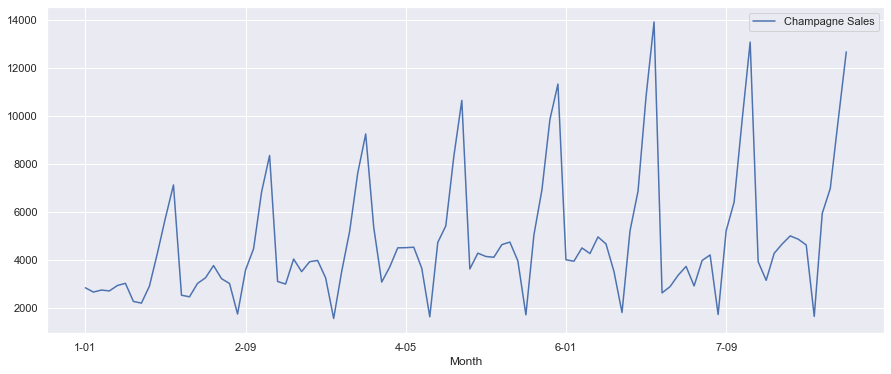

In [22]:
sns.set(rc={'figure.figsize':(15, 6)})
df.plot(x='Month', y='Champagne Sales')

In [23]:
# O p-valor maior que 0.05 mostra que a série não é estacionária
ad_fuller_result = adfuller(df['Champagne Sales'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -1.6391922748046197
p-value: 0.46268288388797046


In [24]:
df['Seasonal Difference'] = df['Champagne Sales'].diff(periods=12)
df.head(15)

,Month,Champagne Sales,Seasonal Difference
0,1-01,2851,NaN
1,1-02,2672,NaN
2,1-03,2755,NaN
3,1-04,2721,NaN
4,1-05,2946,NaN
5,1-06,3036,NaN
6,1-07,2282,NaN
7,1-08,2212,NaN
8,1-09,2922,NaN
9,1-10,4301,NaN


In [27]:
df['Seasonal Difference'] = df['Seasonal Difference'].fillna(0)
df.index = df['Month']
df = df.drop(['Month'], axis=1)
df.head()

,Champagne Sales,Seasonal Difference,1D
Month,,,
1-01,2851,0.0,0.0
1-02,2672,0.0,0.0
1-03,2755,0.0,0.0
1-04,2721,0.0,0.0
1-05,2946,0.0,0.0


In [60]:
# como o p-valor é maior que 0.05, é necessário fazer uma primeira diferenciação
ad_fuller_result = adfuller(df['Seasonal Difference'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -7.557711572794621
p-value: 3.067997430812974e-11


In [25]:
df['1D'] = df['Seasonal Difference'].diff()
df['1D'] = df['1D'].fillna(0)
df.head(25)

,Month,Champagne Sales,Seasonal Difference,1D
0,1-01,2851,NaN,0.0
1,1-02,2672,NaN,0.0
2,1-03,2755,NaN,0.0
3,1-04,2721,NaN,0.0
4,1-05,2946,NaN,0.0
5,1-06,3036,NaN,0.0
6,1-07,2282,NaN,0.0
7,1-08,2212,NaN,0.0
8,1-09,2922,NaN,0.0
9,1-10,4301,NaN,0.0


In [28]:
# com o p-valor menor que 0,05, a série temporal é estacionária
ad_fuller_result = adfuller(df['1D'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -4.367486034494896
p-value: 0.0003387300363606189


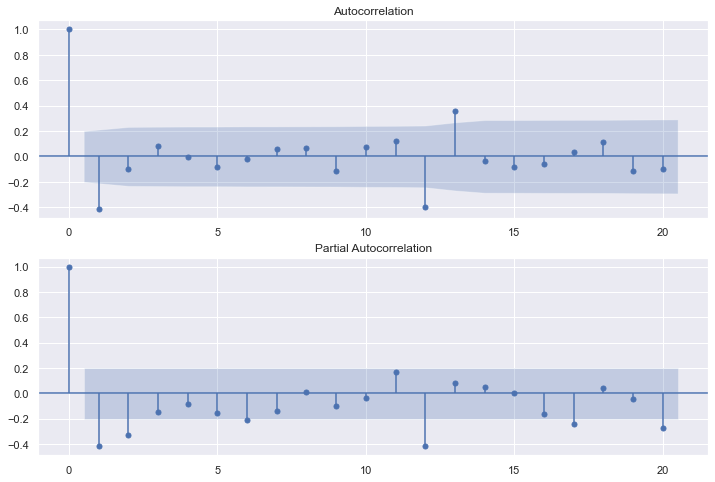

In [29]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['1D'].values.squeeze(), ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['1D'], ax=ax2)

# 2) Modelagem

Para criar o modelo SARIMA, selecionei os seguintes critérios:

Como o gráfico acima mostra um lag-1 positivo e com os dois primeiros lags significativos, selecionei um modelo autoregressivo com p=2 e P=1. Como geralmente modelos autoregressivos não possuem componente de média móvel, q=0 e Q=0.
A série sofreu duas diferenciações: a diferenciação sazonal e a primeira diferenciação. Por isso, d=1 e D=1.
Por fim, a sazonalidade do modelo é mensal, levando a m=12.

Portanto, tem-se:
ARIMA(p, d, q)(P, D, Q)m -> ARIMA(2, 1, 0)(1, 1, 0)12

In [35]:
# validation sample
train = df[:-6]
test = df[90:96]

In [38]:
mod = SARIMAX(train['1D'], order=(2, 1, 0), seasonal_order=(1, 1, 0, 12))
res = mod.fit()
print(res.summary())

C:\Users\Victoria\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\Users\Victoria\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


                                     SARIMAX Results                                      
Dep. Variable:                                 1D   No. Observations:                   90
Model:             SARIMAX(2, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -656.857
Date:                            Sat, 23 Oct 2021   AIC                           1321.715
Time:                                    18:46:41   BIC                           1331.090
Sample:                                         0   HQIC                          1325.465
                                             - 90                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8432      0.080    -10.604      0.000      -0.999      -0.687
ar.L2         -0.4969      0.124   

# 3) Previsão

Os últimos seis valores da série temporal foram separados do modelo para verificar-se a acurácia de previsão do modelo. Assim, foram previstos seis valores e comparei os valores previstos com os valores adquiridos.

In [70]:
forecast = res.forecast(6)

C:\Users\Victoria\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


In [71]:
test['Champagne Sales']

Month
8-07     4633
8-08     1659
8-09     5951
8-10     6981
8-11     9851
8-12    12670
Name: Champagne Sales, dtype: int64

In [72]:
forecast

90     174.579479
91     657.467582
92    -279.514548
93     -52.929834
94     849.090816
95    1341.931746
Name: predicted_mean, dtype: float64

In [73]:
prediction = test['Champagne Sales'] + forecast.values

In [74]:
real = test['Champagne Sales'] + test['1D']
real

Month
8-07     4161.0
8-08     1164.0
8-09     6760.0
8-10     6808.0
8-11     9303.0
8-12    12255.0
dtype: float64

In [79]:
prediction - real

Month
8-07     646.579479
8-08    1152.467582
8-09   -1088.514548
8-10     120.070166
8-11    1397.090816
8-12    1756.931746
dtype: float64

# 4) Avaliação do modelo

Para avaliar o modelo, plotei o diagnóstico do modelo. O gráfico ACF mostra que o lag-1 é maior que um desvio padrão e, por isso, o modelo provavelmente não é o melhor. O gráfico dos resíduos padrões também mostra que existem valores acima de 3 desvios padrões, mostrando que o modelo poderia ser aprimorado.

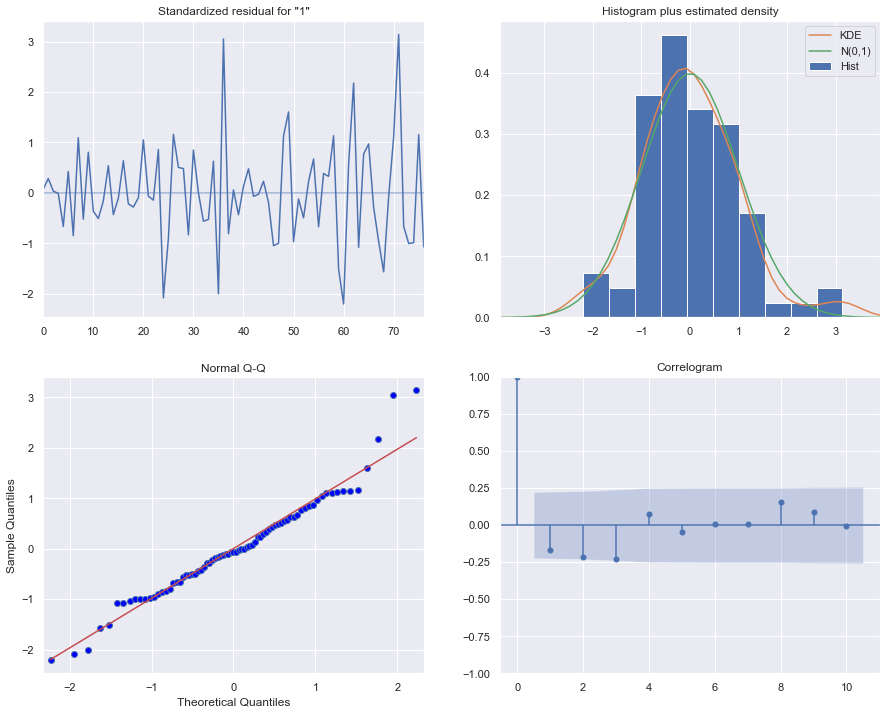

In [77]:
res.plot_diagnostics(figsize=(15, 12))
plt.show()